<a href="https://colab.research.google.com/github/DiegoStevenVera/name_it_backend/blob/master/Name_It.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchvision import models
from torchsummary import summary
from torchvision import transforms
from PIL import Image

import torch

In [ ]:
resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
img = Image.open("hourse.jpg")
with open('imagenet_classes.txt') as f:
  labels = [line.strip() for line in f.readlines()]

In [ ]:
preprocess = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(
  mean=[0.485, 0.456, 0.406],
  std=[0.229, 0.224, 0.225]
)])

In [ ]:
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)
batch_t.shape

torch.Size([1, 3, 224, 224])

In [ ]:
out = resnet(batch_t)
out.shape

torch.Size([1, 1000])

In [ ]:
_, index = torch.max(out, 1)
index

tensor([339])

In [ ]:
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
labels[index[0]], percentage[index[0]].item()

('sorrel', 76.73075866699219)

# LSTM

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import random
import os

In [ ]:
adj = ["capaz", "superior", "absoluto", "aceptado", "preciso", "as", "activo", "real", "adaptado", "adaptando", "adecuado", "ajustado", "avanzado", "alerta", "vivo", "permitido", "permitiendo", "asombrado", "asombroso", "amplio", "divertido", "divertido", "aparente", "apto", "llegando", "artístico", "seguro", "asegurador", "esperado", "despierto", "consciente", "equilibrado", "llegando a ser", "amado", "mejor", "grande", "bendecido", "audaz", "jefe", "valiente", "breve", "brillante", "estallido", "ocupado", "calmado", "capaz", "capital", "cuidadoso", "cariñoso", "casual", "causal", "central", "cierto", "campeón", "encantado", "encantador", "alegre", "jefe", "elección", "civil", "clásico", "limpio", "claro", "inteligente", "escalada", "cerca", "cierre", "coherente", "cómico", "comunitario", "completo", "compuesto", "conciso", "concreto", "contenido", "cool", "correcto", "cósmico", "crack", "creativo", "creíble", "nítido", "crucial", "tierno", "astuto", "curioso", "actual", "lindo", "atrevido", "querido", "apuesto", "querido", "decente", "decisivo", "profundo", "definido", "d elicado", "deseado", "destinado", "dedicado", "directo", "discreto", "distinto", "diverso", "divino", "dominante", "impulsado", "impulsor", "dinámico" , "ansioso", "fácil", "eléctrico", "elegante", "emergente", "eminente", "habilitado", "habilitador", "sin fin", "comprometido", "atractivo", "mejorado", " disfrutado", "enorme", "bastante", "épico", "igual", "equipado", "eterno", "ético", "evidente", "evolucionado", "evolutivo", "exacto", "emocionado" , "emocionante", "exótico", "experto", "real", "justo", "fiel", "famoso", "elegante", "rápido", "factible", "bien", "más fino", " firme", "primero", "encajar", "adecuado", "flota", "flexible", "fluido", "fluido", "volador", "cariñoso", "franco", "libre", "fresco" , "completo", "divertido", "funky", "gracioso", "juego", "generoso", "suave", "genuino", "dar", "alegre", "glorioso", "brillante", " dorado", "bueno", "magnífico", "grandioso", "agradecido", "genial", "creciente", "crecido", "guiado", "guía", "práctico", "feliz", "resistente" , "inofensivo", "sano", "ayudado", "útil", "ayudando", "heroico", "cadera", "santo", "honesto", "esperanzado", "ho t", "enorme", "humano", "humilde", "humorístico", "ideal", "inmenso", "inmortal", "inmune", "mejorado", "en", "incluido", "infinito" , "informado", "inocente", "inspirado", "integral", "intenso", "intento", "interno", "íntimo", "invitador", "junto", "justo", "agudo", " clave", "amable", "conocedor", "conocido", "grande", "duradero", "principal", "aprendizaje", "legal", "legible", "indulgente", "liberal", "ligero" , "gustado", "alfabetizado", "vivo", "vivo", "lógico", "amado", "amoroso", "leal", "afortunado", "mágico", "magnético", "principal", " mayor", "muchos", "masivo", "maestro", "maduro", "máximo", "medido", "reunirse", "alegre", "poderoso", "menta", "modelo", "moderno" , "modesto", "moral", "más", "emocionado", "emocionado", "musical", "mutuo", "nacional", "nativo", "natural", "cercano", "pulcro", " necesario", "neutral", "nuevo", "siguiente", "agradable", "noble", "normal", "notable", "señalado", "novedoso", "atento", "en", "uno" , "abierto", "óptimo", "óptimo", "orgánico", "orientado", "extrovertido", "paciente", "pacífico", "perfecto", "mascota", "recogido", "agradable", " por favor d", "agradable", "poético", "pulido", "educado", "popular", "positivo", "posible", "poderoso", "precioso", "preciso", "premium", "preparado" , "presente", "bonita", "primaria", "principal", "pro", "probable", "profunda", "promovida", "rápida", "adecuada", "orgullosa", "probada", " bombeado", "puro", "calidad", "rápido", "silencioso", "rápido", "raro", "racional", "listo", "real", "refinado", "regular", "relacionado" , "relativo", "relajado", "relajante", "relevante", "aliviado", "renovado", "renovador", "resuelto", "descansado", "rico", "correcto", "robusto", " romántico", "gobernante", "sagrado", "seguro", "salvado", "salvador", "seguro", "seleccionado", "seleccionado", "sensato", "establecido", "establecido", "establecido" , "compartir", "afilado", "brillante", "simple", "sincero", "singular", "hábil", "inteligente", "sensacional", "sonriente", "suave", "social", " sólido", "buscado", "sonido", "especial", "espléndido", "cuadrado", "estable", "estrella", "estable", "sterling", "todavía", "agitado", "revolviendo" , "llamativo", "fuerte", "impresionante", "sutil", "adecuado", "adecuado", "resumen", "soleado", "súper", "soberbio", "supremo", "seguro", "arrollador", "dulce", "talentoso", "enseñante", "tierno", "agradecido", "minucioso", "ordenado", "apretado", "juntos", "tolerante", "top", "tópica", "tops", "tocado", "tocando", "duro", "verdadero", "de confianza", "confiado", "de confianza", "último", "imparcial", "poco común", "unificado", "único", "unido", "arriba", "vertical", "hacia arriba", "utilizable", "útil", "válido", "valorado", "vasto", "verificado", "viable", "vital", "vocal", "querido", "cálido", "rico", "bienvenido", "bienvenido", "bien", "todo", "dispuesto", "ganador", "cableado", "sabio", "ingenioso", "maravilloso", "viable", "trabajando", "digno"]
adv = ["anormalmente", "absolutamente", "exactamente", "activamente", "en realidad", "adecuadamente", "admitidamente", "adversamente", "supuestamente", "sorprendentemente", "anualmente", "aparentemente", "posiblemente ", "terriblemente", "mal", "apenas", "básicamente", "descaradamente", "a ciegas", "brevemente", "brillantemente", "en general", "cuidadosamente", "centralmente", "ciertamente", "barato", "limpiamente", "claramente", "cerca", "comúnmente", "completamente", "constantemente", "al revés", "correctamente", "curiosamente", "actualmente", "diariamente", "mortal ", "profundamente", "definitivamente", "directamente", "claramente", "debidamente", "con entusiasmo", "temprano", "fácilmente", "eminentemente", "sin fin", "enormemente", "totalmente", "igualmente", "especialmente", "parcialmente", "evidentemente", "exactamente", "explícitamente", "externamente", "extremadamente", "fácticamente", "bastante", "finalmente", "firmemente", "primero ", "a la fuerza", "formalmente", "anteriormente", "francamente", "libremente", "frecuentemente", "amistoso", "totalmente", "generalmente", "suavemente", "genuinamente", "horrible", "con mucho gusto", "globalmente", "gradualmente", "agradecido", "mucho", "groseramente", "felizmente", "apenas", "corazón", "muy", "horriblemente", "muy", "honestamente", "con suerte", "desesperadamente", "horriblemente", "enormemente", "humildemente", "idealmente", "ilegalmente", "inmensamente" , "implícitamente", "increíblemente", "indirectamente", "infinitamente", "informalmente", "inherentemente", "inicialmente", "instantáneamente", "intensamente", "internamente", "conjuntamente", "alegre", " amablemente", "en gran parte", "últimamente", "legalmente", "ligeramente", "probable", "literalmente", "animado", "localmente", "lógicamente", "holgadamente", "en voz alta", "encantador" , "afortunadamente", "principalmente", "manualmente", "marginalmente", "mentalmente", "meramente", "levemente", "miserablemente", "equivocadamente", "moderadamente", "mensualmente", "moralmente", " en su mayoría", "multiplicar", "mutuamente", "a saber", "nacionalmente", "naturalmente", "casi", "pulcramente", "innecesariamente", "nuevamente", "bien", "nominalmente", "normalmente" , "notablemente", "notablemente", "obviamente", "extrañamente", "oficialmente", "solo", "abiertamente", "opcionalmente", "demasiado", "dolorosamente", "parcialmente", "parcialmente", " perfectamente", "personalmente", "físicamente", "claramente", "agradablemente", "mal", "positivamente", "posiblemente", "precisamente", "preferiblemente", "actualmente", "presuntamente", "anteriormente", "principalmente", "en privado", "probablemente", "prontamente", "adecuadamente", "públicamente", "puramente", "rápidamente", "en silencio" , "radicalmente", "al azar", "rápidamente", "raramente", "racionalmente", "fácilmente", "realmente", "razonablemente", "recientemente", "regularmente", "fiablemente", "notablemente", " remotamente", "repetidamente", "correctamente", "aproximadamente", "rutinariamente", "tristemente", "seguramente", "apenas", "en segundo lugar", "en secreto", "aparentemente", "sensatamente", "por separado" , "seriamente", "severamente", "bruscamente", "brevemente", "similarmente", "simplemente", "sinceramente", "singularmente", "ligeramente", "lentamente", "suavemente", "socialmente", " únicamente", "especialmente", "constantemente", "extrañamente", "estrictamente", "fuertemente", "sutilmente", "de repente", "adecuadamente", "supuestamente", "seguramente", "finalmente", "terriblemente" , "afortunadamente", "completamente", "firmemente", "totalmente", "trivialmente", "verdaderamente", "típicamente", "en última instancia", "indebidamente", "uniformemente", "únicamente", "improbable", " urgentemente", "utilmente", "usualmente", "absolutamente", "vagamente", "enormemente", "verbalmente", "verticalmente", "vigorosamente", "violentamente", "virtualmente", "visualmente", "semanalmente", "totalmente", "ampliamente", "salvajemente", "voluntariamente", "incorrectamente", "anualmente"]

adj = [adi.strip() for adi in adj]
adv = [adi.strip() for adi in adv]

with open('imagenet_classes.txt') as f:
  names = [line.strip() for line in f.readlines()]

print(f"Adj: {len(adj)} - Adv: {len(adv)} - Names: {len(names)}")

Adj: 449 - Adv: 261 - Names: 1000


sujeto + advervio + adjetivo

In [ ]:
num_iters = 5 # cantidad de veces que cada nombre de animal se usará
len_names = len(names)

In [ ]:
pet_names = np.zeros((num_iters*len_names, 4), dtype=object) #corpus

for e in range(5):
  for i, name in enumerate(names):
    pet_names[i+(e*1000)][1] = name
    pet_names[i+(e*1000)][2] = adv[np.random.randint(0,len(adv))]
    pet_names[i+(e*1000)][3] = adj[np.random.randint(0,len(adj))]

In [ ]:
pet_names[:, 0] = ' '

In [ ]:
pet_names.shape

(5000, 3)

In [ ]:
all_tokens = np.concatenate([names, np.unique(pet_names[:,2]), np.unique(pet_names[:,3]), [' ']])
len_tokens = all_tokens.shape[0]
ds_size = 2*num_iters*len_names

In [ ]:
X = np.zeros((ds_size, 2, len_tokens), dtype=int)
y = np.zeros((ds_size, len_tokens), dtype=int)

for e in range(num_iters*len_names):
  for i in range(2):
    X[2*e+i, 0, np.where(all_tokens == pet_names[e, i])[0][0]] = 1
    X[2*e+i, 1, np.where(all_tokens == pet_names[e, i+1])[0][0]] = 1
    y[2*e+i, np.where(all_tokens == pet_names[e, i+2])] = 1

print(f"Shape: X - {X.shape}, y - {y.shape}")

Shape: X - (10000, 2, 1612), y - (10000, 1612)


In [ ]:
latent_dim = 64
dropout_rate = 0.2

model = Sequential()
model.add(LSTM(latent_dim,
               input_shape=(2, len_tokens),
               recurrent_dropout=dropout_rate))
model.add(Dense(units=len_tokens, activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                429312    
                                                                 
 dense (Dense)               (None, 1612)              104780    
                                                                 
Total params: 534,092
Trainable params: 534,092
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 50
batch_size = 32
verbosity = 1

start = time.time()
print('Start training for {} epochs'.format(epochs))
history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=verbosity)
end = time.time()
print('Finished training - time elapsed:', (end - start)/60, 'min')

Start training for 50 epochs
Epoch 1/50
313/313 [==============================] - 9s 19ms/step - loss: 7.4134
Epoch 2/50
313/313 [==============================] - 5s 15ms/step - loss: 6.6587
Epoch 3/50
313/313 [==============================] - 5s 15ms/step - loss: 6.4417
Epoch 4/50
313/313 [==============================] - 6s 19ms/step - loss: 6.2335
Epoch 5/50
313/313 [==============================] - 5s 15ms/step - loss: 6.1981
Epoch 6/50
313/313 [==============================] - 6s 19ms/step - loss: 6.1943
Epoch 7/50
313/313 [==============================] - 5s 15ms/step - loss: 6.1950
Epoch 8/50
313/313 [==============================] - 5s 15ms/step - loss: 6.2112
Epoch 9/50
313/313 [==============================] - 6s 19ms/step - loss: 6.2107
Epoch 10/50
313/313 [==============================] - 5s 15ms/step - loss: 6.1881
Epoch 11/50
313/313 [==============================] - 6s 19ms/step - loss: 6.1504
Epoch 12/50
313/313 [==============================] - 5s 16ms/step

In [ ]:
model_path = os.path.realpath('./pet_name_generator.h5')

print('Storing model at:', model_path)
model.save(model_path)

Storing model at: /content/pet_name_generator.h5


In [ ]:
def predict_name(type_pet_index, dict_tokens):
  x = np.zeros((1, 2, len_tokens))
  x[0,0, np.where(all_tokens == ' ')[0][0]] = 1
  x[0,1, type_pet_index] = 1
  
  adv_i = model.predict(x, verbose=0)[0].argmax()

  x = np.zeros((1, 2, len_tokens))
  x[0,0, type_pet_index] = 1
  x[0,0, adv_i] = 1
  adj_i = model.predict(x, verbose=0)[0].argmax()

  return dict_tokens[type_pet_index] \
          + ' ' + dict_tokens[adv_i] \
          + ' ' + dict_tokens[adj_i]

In [ ]:
predict_name(339, all_tokens)

'sorrel principalmente alegre'

In [ ]:
name_to_predict = 'sorrel'
x = np.zeros((1, 2, len_tokens))
x[0,0, np.where(all_tokens == ' ')[0][0]] = 1
x[0,1, np.where(all_tokens == name_to_predict)[0][0]] = 1
x

array([[[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [ ]:
probs = model.predict(x, verbose=0)[0]
probs

array([4.1629752e-05, 3.6822134e-05, 3.5923214e-05, ..., 1.3200517e-04,
       1.5904696e-04, 3.9887527e-05], dtype=float32)

In [ ]:
nam_i = np.where(all_tokens == name_to_predict)[0][0]
adv_i = probs.argmax()
nam_i, adv_i

(339, 1161)

In [ ]:
x_1 = np.zeros((1, 2, len_tokens))
x_1[0,0, nam_i] = 1
x_1[0,1, adv_i] = 1
x_1

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [ ]:
probs2 = model.predict(x_1, verbose=0)[0]
probs2

array([0.00019806, 0.00019271, 0.00018467, ..., 0.00275461, 0.00319602,
       0.00020492], dtype=float32)

In [ ]:
adj_i = probs2.argmax()
adj_i

1234

In [ ]:
all_tokens[nam_i] + ' ' + all_tokens[adv_i] + ' ' + all_tokens[adj_i]

'sorrel principalmente alegre'

# Resnet101 + LSTM

In [ ]:
from tensorflow.keras.applications import resnet
from tensorflow.keras.preprocessing import image
from torchvision import transforms
from PIL import Image

In [ ]:
model_resnet = resnet.ResNet101()

179648224/179648224 [==============================] - 1s 0us/step


In [ ]:
model_path = os.path.realpath('./resnet101.h5')

print('Storing model at:', model_path)
model.save(model_path)

Storing model at: /content/resnet101.h5


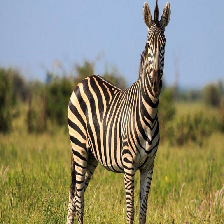

In [ ]:
img = image.load_img('cebra.jpg', target_size=(224,224))
img

In [ ]:
img_array = image.img_to_array(img)
img_prepro = resnet.preprocess_input(img_array)
img_batch = np.expand_dims(img_prepro, axis=0)
img_array.shape, img_prepro.shape, img_batch.shape

((224, 224, 3), (224, 224, 3), (1, 224, 224, 3))

In [ ]:
predict_model_img = model_resnet.predict(img_batch)
predict_model_img.shape

1/1 [==============================] - 0s 328ms/step


(1, 1000)

In [ ]:
resnet.decode_predictions(predict_model_img)

[[('n02391049', 'zebra', 0.9773695),
  ('n02422106', 'hartebeest', 0.0071663302),
  ('n02422699', 'impala', 0.0047944137),
  ('n02423022', 'gazelle', 0.0041620913),
  ('n01518878', 'ostrich', 0.0011940598)]]

In [ ]:
def predict_name_pet_from_img(path_img):
  img = image.load_img(path_img, target_size=(224,224))
  img_array = image.img_to_array(img)
  img_prepro = resnet.preprocess_input(img_array)
  img_batch = np.expand_dims(img_prepro, axis=0)

  pred = model_resnet.predict(img_batch)
  return predict_name(pred.argmax(), all_tokens)

In [ ]:
predict_name_pet_from_img('cebra.jpg')

1/1 [==============================] - 0s 342ms/step


'zebra socialmente seguro'

In [ ]:
with open('all_tokens.npy', 'wb') as f:
    np.save(f, all_tokens)

# Model Complete

In [ ]:
from tensorflow.keras.applications import resnet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

Carga de modelos

In [ ]:
with open('all_tokens.npy', 'rb') as f:
    all_tokens = np.load(f, allow_pickle=True)
all_tokens.shape

(1612,)

In [ ]:
latent_dim = 64
dropout_rate = 0.2
len_tokens = all_tokens.shape[0]

pet_generator = Sequential()
pet_generator.add(LSTM(latent_dim,
               input_shape=(2, len_tokens),
               recurrent_dropout=dropout_rate))
pet_generator.add(Dense(units=len_tokens, activation='softmax'))

optimizer = RMSprop(learning_rate=0.01)
pet_generator.compile(loss='categorical_crossentropy', optimizer=optimizer)

model_path = os.path.realpath('./pet_name_generator.h5')
pet_generator.load_weights(model_path)
model_resnet = resnet.ResNet101()

In [ ]:
def predict_name(type_pet_index, dict_tokens):
  x = np.zeros((1, 2, dict_tokens.shape[0]))
  x[0,0, np.where(dict_tokens == ' ')[0][0]] = 1
  x[0,1, type_pet_index] = 1
  
  adv_i = pet_generator.predict(x, verbose=0)[0].argmax()

  x = np.zeros((1, 2, len_tokens))
  x[0,0, type_pet_index] = 1
  x[0,0, adv_i] = 1
  adj_i = pet_generator.predict(x, verbose=0)[0].argmax()

  return dict_tokens[type_pet_index] \
          + ' ' + dict_tokens[adv_i] \
          + ' ' + dict_tokens[adj_i]

In [ ]:
def predict_name_pet_from_img(path_img):
  img = image.load_img(path_img, target_size=(224,224))
  plt.imshow(img)
  img_array = image.img_to_array(img)
  img_prepro = resnet.preprocess_input(img_array)
  img_batch = np.expand_dims(img_prepro, axis=0)

  pred = model_resnet.predict(img_batch)
  return predict_name(pred.argmax(), all_tokens)

1/1 [==============================] - 3s 3s/step


'golden retriever exactamente alegre'

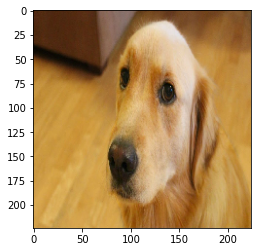

In [ ]:
predict_name_pet_from_img('bobby.jpg')